# Transfer Learning using VGG16 on Flowers Dataset

This notebook demonstrates transfer learning using the pre-trained **VGG16** model on the [5 Flower Types Classification Dataset](https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset/data).

We will use PyTorch for implementing transfer learning.

### **Objectives**
- Load and preprocess the dataset
- Use pre-trained VGG16 as a feature extractor
- Fine-tune the classifier head for flower classification
- Evaluate model performance on validation/test data

---

In [1]:
import os
files = []
for dirname, _, filenames in os.walk('./flower_images'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

for f in files[:10]:
    print(f)

print(f"... a total of {len(files)} files listed")

./flower_images\Lilly\00048a5c76.jpg
./flower_images\Lilly\001ff6644e.jpg
./flower_images\Lilly\001ff6656j.jpg
./flower_images\Lilly\00973ad1b1.jpg
./flower_images\Lilly\00a7d512d6.jpg
./flower_images\Lilly\00f36a3c40.jpg
./flower_images\Lilly\013628cccc.jpg
./flower_images\Lilly\01998d6fb5.jpg
./flower_images\Lilly\01a0ec319c.jpg
./flower_images\Lilly\01b4bb0289.jpg
... a total of 5000 files listed


## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
from torchvision import datasets, transforms, models, utils
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import random

## 2. Data Preparation

The dataset is downloaded and extracted in the following structure:

```
flower_images/
    Lilly/
    Lotus/
    Orchid/
    Sunflower/
    Tulip/
```

We define an image transformation pipeline using torchvision.transforms:

`Resize` – All images are resized to 224 × 224 pixels to ensure uniform input size for the model.

`ToTensor` – Converts images into PyTorch tensors and normalizes pixel values to the range [0, 1].

`Normalize` - Standardizes images with mean = [0.485, 0.456, 0.406] and std dev =  [0.229, 0.224, 0.225]

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root="./flower_images/", transform=transform)

print(f"Total images: {len(dataset)}")

train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Total images: 4999
Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
Train size: 3999, Test size: 1000


## 3. Visualize a Few Training Images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


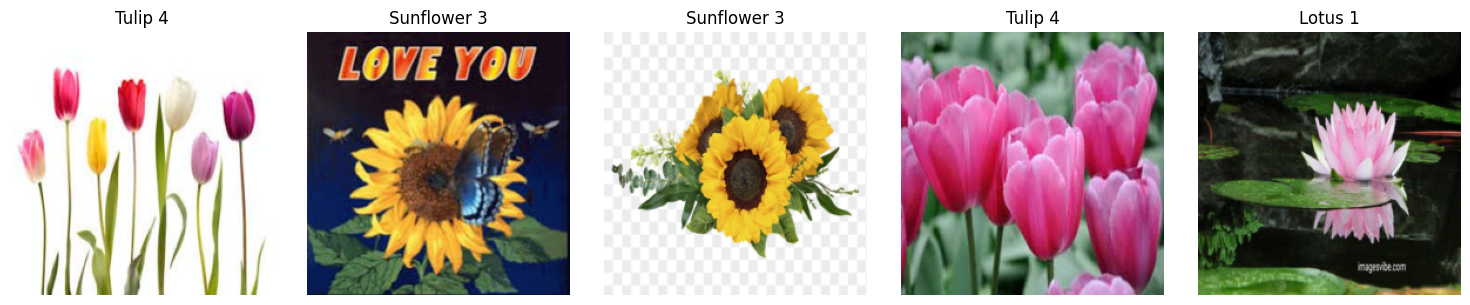

In [4]:
def visualize_sample(dataset, class_name, num_sample=5):
    indices = random.sample(range(len(dataset)), num_sample)
    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        print(image.size())

        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)

        plt.subplot(1, num_sample, i+1)
        plt.imshow(image)
        plt.title(f"{class_name[label]} {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_sample(dataset=dataset, class_name=class_names, num_sample=5)

## 4. Load Pre-trained VGG16 Model

We load the pre-trained **VGG16** model from `torchvision.models`, freeze its convolutional layers, and modify the classifier head for our number of flower classes.

In [5]:
vgg16 = models.vgg16(pretrained=True)

c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 5. Freezing the feature extractor part and add a custom classification layer

In [7]:
for param in vgg16.features.parameters():
    param.requires_grad = False

For the last layer, because the number of class labels differs compared to ImageNet, we replace the output layer with your own output layer

In [8]:
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, len(class_names))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = vgg16.to(device)

print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


## 6. Define Loss Function and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)   # This will only update the last layer of the classifier

# If you want to modify the weights of the entire classification layers thenuse the following code

# optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

## 7. Training Loop

In [10]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'Training Loss: {epoch_loss:.4f} | Acc: {100*epoch_acc:.2f}%')

    return model

## 8. Train the Model

In [11]:
model_trained = train_model(vgg16, criterion, optimizer, num_epochs=5)

Epoch 1/5
--------------------
Training Loss: 0.7490 | Acc: 71.79%
Epoch 2/5
--------------------
Training Loss: 0.5154 | Acc: 81.52%
Epoch 3/5
--------------------
Training Loss: 0.4735 | Acc: 82.52%
Epoch 4/5
--------------------
Training Loss: 0.4454 | Acc: 83.82%
Epoch 5/5
--------------------
Training Loss: 0.4206 | Acc: 85.00%


## 9. Evaluate the Model on Test Data

In [12]:
model_trained.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_trained(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 86.20%


## 10. Save the Trained Model

In [13]:
torch.save(model_trained.state_dict(), 'vgg16_flowers.pth')
print('Model saved as vgg16_flowers.pth')

Model saved as vgg16_flowers.pth
